# Training Classification Models

The following models will be tested:
1. Logistic Regression
2. K-Nearest-Neighbors
3. Complement Naive-Bayes
4. Random Forest
5. XGBoost
6. SVM with Kernel Trick

This dataset is a part of a competition of *drivendata.org*, so the test inputs are provided without their targets.
A submission can be made on their platform on order to evaluate a classifier, however only 3 submissions per account
are allowed each day. For that reason, 10% of the training samples will be chosen as test samples, in order to pick
the best-performing classifiers. Then, these classifiers will be tuned using 10-Fold Cross-Validation and **Optuna** library.

# Importing Train-Test Datasets

In [21]:
import pandas as pd

train_inputs = pd.read_csv('train_inputs.csv')
train_targets = pd.read_csv('targets.csv')
test_inputs = pd.read_csv('test_inputs.csv')

train_inputs.shape, train_targets.shape, test_inputs.shape

((59400, 42), (59400, 2), (14850, 42))

# Dropping Columns

All extra columns that contain no useful information are dropped from the dataset.

In [22]:
test_input_ids = test_inputs['id']

columns_to_drop = [
    'id', 'date_recorded', 'longitude', 'latitude', 'wpt_name', 'num_private', 'subvillage', 'region', 'ward', 'recorded_by',
    'scheme_name', 'construction_year', 'extraction_type', 'extraction_type_class', 'management_group', 'payment', 'quality_group',
    'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group',
]

train_inputs = train_inputs.drop(columns=columns_to_drop)
test_inputs = test_inputs.drop(columns=columns_to_drop)

train_inputs.shape, test_inputs.shape

((59400, 21), (14850, 21))

# Encoding Targets

There are 3 classes:

1. `functional`: The pump is functional
2. `functional needs repair`: The pump is function but it is damaged, so it needs immidiate repair
3. `non functional`: The pump is damaged and not operating at all

In [23]:
train_targets = train_targets['status_group'].replace({'functional': 0, 'functional needs repair': 1, 'non functional': 2}).astype(int)
train_targets

0        0
1        0
2        0
3        2
4        0
        ..
59395    0
59396    0
59397    0
59398    0
59399    0
Name: status_group, Length: 59400, dtype: int32

# Encoding Inputs

Inputs of this dataset are both numerical and categorical, so inputs must first be encoded before fed into the classifiers.
The following encoders will be used:
1.   `Ordinal (Label) Encoding`: Converts categorical variables to ordered numerical values
2.   `Count Encoder`: Replaces each categorical variable with its frequency count in the column
3.   `Hashing Encoding`: Hashes categorical variables to unique one-hot vectors with configurable dimensionality
4.   `Backward Difference Encoder`: The mean of the $k_{th}$ categorical variable is compared with the mean of the $k_{th} - 1$
5.    `Helmert Encoding`: The mean of the $k_{th}$ categorical variable is compared with the means of all previous categorical variables
6.   `Cat Boost Encoding` Similar to `Target Encoder`, which converts each categorical value with the mean appearance of its target, but also involves an ordering principle, in order to overcome the `"Target Leakage"` problem
7.   `Generalized Linear Mixed Model Encoder`: A supervised encoder similar to `Target Encoder`, but solid statistical theory is also included. The advantage over other supervised encoders is that no parameter tuning is needed

In [24]:
from category_encoders import OrdinalEncoder
from category_encoders import CountEncoder
from category_encoders import HashingEncoder
from category_encoders import BackwardDifferenceEncoder
from category_encoders import HelmertEncoder
from category_encoders import CatBoostEncoder
from category_encoders import GLMMEncoder

random_state = 0

encoding_methods = {
    'ordinal': OrdinalEncoder(),
    'count': CountEncoder(),
    'hashing': HashingEncoder(n_components=32, drop_invariant=True),
    'backward_difference': BackwardDifferenceEncoder(),
    'Helmert': HelmertEncoder(),
    'CatBoost': CatBoostEncoder(random_state=random_state),
    'GLMM': GLMMEncoder(random_state=random_state)
}

# Building Classifier Configurations
--------------------------

* Logistic Regression (`sklearn.linear_model`)
* K-Nearest Neighbors (`sklearn.neighbors`)
* Gaussian Naive Bayes (`sklearn.naive_bayes`)
* Random Forest (`sklearn.ensemble`)
* SVM (`sklearn.svm`)
* XGBoost (`xgboost`)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

random_state = 0

classifiers = {
    'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=random_state),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=35, weights='distance', n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1),
    'Support Vector Machine': SVC(random_state=random_state)
}

# Training Classifiers

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

x_train, x_test, y_train, y_test = train_test_split(
    train_inputs, train_targets, test_size=0.1, random_state=random_state
)

classifier_best_results = {classifier_name: (0, 'encoder') for classifier_name in classifiers.keys()}


for encoding_method, encoder in encoding_methods.items():
    print(f'\n----- Encoding data using {encoding_method} Encoder -----', end='')

    start_time = time.time()

    encoded_x_train = encoder.fit_transform(x_train, y_train)
    encoded_x_test = encoder.transform(x_test)

    end_time = time.time()
    print(f'Done in {round(end_time-start_time, 2)}s')

    for classifier_name, clf_algorithm in classifiers.items():
        print(f'Training {classifier_name} Classifier', end='')

        start_time = time.time()

        clf_algorithm.fit(encoded_x_train, y_train)
        y_pred = clf_algorithm.predict(encoded_x_test)
        acc = accuracy_score(y_test, y_pred)

        end_time = time.time()
        print(f'Done in {round(end_time-start_time, 2)}s')

        previous_acc, _ = classifier_best_results[classifier_name]
        if previous_acc < acc:
            classifier_best_results[classifier_name] = (acc, encoding_method)


for classifier_name, (score, encoding_method) in classifier_best_results.items():
    print(f'\nClassifier: {classifier_name}\tBest Score: {score} on Test Data\t Using {encoding_method} Encoder')


----- Encoding data using ordinal Encoder -----Done in 0.29s
Training Logistic Regression ClassifierDone in 2.13s
Training K-Nearest Neighbors ClassifierDone in 0.3s
Training Naive Bayes ClassifierDone in 0.02s
Training Random Forest ClassifierDone in 0.76s
Training XGBoost ClassifierDone in 2.7s
Training Support Vector Machine ClassifierDone in 108.61s

----- Encoding data using count Encoder -----Done in 0.5s
Training Logistic Regression ClassifierDone in 1.53s
Training K-Nearest Neighbors ClassifierDone in 0.26s
Training Naive Bayes ClassifierDone in 0.02s
Training Random Forest ClassifierDone in 0.79s
Training XGBoost ClassifierDone in 2.65s
Training Support Vector Machine ClassifierDone in 99.19s

----- Encoding data using hashing Encoder -----Done in 14.3s
Training Logistic Regression ClassifierDone in 2.06s
Training K-Nearest Neighbors ClassifierDone in 0.31s
Training Naive Bayes ClassifierDone in 0.04s
Training Random Forest ClassifierDone in 0.89s
Training XGBoost ClassifierD

# Detailed Classification Report

The goal of this competition is to build a classifier with the highest accuracy. However,
since this is an imbalanced dataset, it is more appropriate to rely on **Precision & Recall**.

In [20]:
from sklearn.metrics import classification_report
import seaborn as sns

scores = []
pipelines = []

for classifier_name, metric in classifier_best_results.items():
    score, encoding_method = metric
    encoder = encoding_methods[encoding_method]
    encoded_x_train = encoder.fit_transform(x_train, y_train)
    encoded_x_test = encoder.transform(x_test)

    clf = classifiers[classifier_name]
    clf.fit(encoded_x_train, y_train)
    y_pred = clf.predict(encoded_x_test)

    scores.append(score)
    pipelines.append(classifier_name + ' - ' + encoding_method)

    print(f'\n-----Classifier: {classifier_name}\tEncoding: {encoding_method}-----')
    print(classification_report(y_test, y_pred))


-----Classifier: Logistic Regression	Encoding: Helmert-----
              precision    recall  f1-score   support

           0       0.67      0.84      0.74      3253
           1       0.21      0.01      0.02       424
           2       0.66      0.54      0.60      2263

    accuracy                           0.66      5940
   macro avg       0.51      0.46      0.45      5940
weighted avg       0.63      0.66      0.63      5940


-----Classifier: K-Nearest Neighbors	Encoding: count-----
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3253
           1       0.52      0.29      0.37       424
           2       0.79      0.74      0.76      2263

    accuracy                           0.77      5940
   macro avg       0.70      0.63      0.65      5940
weighted avg       0.76      0.77      0.77      5940


-----Classifier: Naive Bayes	Encoding: CatBoost-----
              precision    recall  f1-score   support

         

C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Text(0, 0.5, 'Pipeline')

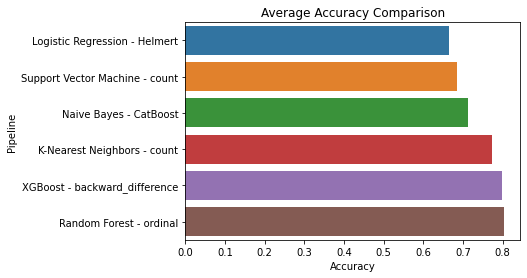

In [36]:
scores, pipelines = zip(*sorted(zip(scores, pipelines)))
scores = list(scores)
pipelines = list(pipelines)

ax = sns.barplot(y=pipelines, x=scores)
ax.set_title('Average Accuracy Comparison')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Pipeline')

# Hyper-Parameter Optimization - K-Nearest Neighbors

In [16]:
from sklearn.model_selection import cross_val_score
import optuna

n_trials = 100

encoder = CountEncoder()
x_train = encoder.fit_transform(train_inputs)

def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, int(train_inputs.shape[0]**(1/2)))
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    avg_acc = cross_val_score(knn_clf, x_train, train_targets, cv=10, n_jobs=-1).mean()
    return avg_acc


knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(knn_objective, n_trials=n_trials)
knn_study.trials_dataframe()

[I 2022-07-13 13:19:57,878] A new study created in memory with name: no-name-7b8c2f87-1199-41fc-b383-18ef2da0cc20
[I 2022-07-13 13:20:00,413] Trial 0 finished with value: 0.6994444444444445 and parameters: {'n_neighbors': 101, 'weights': 'uniform'}. Best is trial 0 with value: 0.6994444444444445.
[I 2022-07-13 13:20:04,188] Trial 1 finished with value: 0.766952861952862 and parameters: {'n_neighbors': 169, 'weights': 'distance'}. Best is trial 1 with value: 0.766952861952862.
[I 2022-07-13 13:20:07,578] Trial 2 finished with value: 0.6944949494949495 and parameters: {'n_neighbors': 120, 'weights': 'uniform'}. Best is trial 1 with value: 0.766952861952862.
[I 2022-07-13 13:20:10,640] Trial 3 finished with value: 0.7247811447811449 and parameters: {'n_neighbors': 40, 'weights': 'uniform'}. Best is trial 1 with value: 0.766952861952862.
[I 2022-07-13 13:20:13,345] Trial 4 finished with value: 0.7438552188552189 and parameters: {'n_neighbors': 16, 'weights': 'uniform'}. Best is trial 1 wit

,number,value,datetime_start,datetime_complete,duration,params_n_neighbors,params_weights,state
0,0,0.699444,2022-07-13 13:19:57.880970,2022-07-13 13:20:00.412597,0 days 00:00:02.531627,101,uniform,COMPLETE
1,1,0.766953,2022-07-13 13:20:00.414589,2022-07-13 13:20:04.188689,0 days 00:00:03.774100,169,distance,COMPLETE
2,2,0.694495,2022-07-13 13:20:04.189659,2022-07-13 13:20:07.578683,0 days 00:00:03.389024,120,uniform,COMPLETE
3,3,0.724781,2022-07-13 13:20:07.579682,2022-07-13 13:20:10.640665,0 days 00:00:03.060983,40,uniform,COMPLETE
4,4,0.743855,2022-07-13 13:20:10.641665,2022-07-13 13:20:13.345806,0 days 00:00:02.704141,16,uniform,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,0.770118,2022-07-13 13:24:19.236398,2022-07-13 13:24:21.698574,0 days 00:00:02.462176,49,distance,COMPLETE
96,96,0.769158,2022-07-13 13:24:21.699576,2022-07-13 13:24:24.263477,0 days 00:00:02.563901,68,distance,COMPLETE
97,97,0.770471,2022-07-13 13:24:24.264478,2022-07-13 13:24:26.624897,0 days 00:00:02.360419,26,distance,COMPLETE
98,98,0.768350,2022-07-13 13:24:26.625781,2022-07-13 13:24:29.001553,0 days 00:00:02.375772,13,distance,COMPLETE


In [17]:
optuna.visualization.plot_contour(knn_study, params=['n_neighbors', 'weights'])

In [18]:
optuna.visualization.plot_param_importances(knn_study)

# Hyper-Parameter Optimization - Random Forest

In [26]:
from sklearn.model_selection import cross_val_score
import optuna

n_trials = 100

encoder = OrdinalEncoder()
x_train = encoder.fit_transform(train_inputs)

def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    optimizer = trial.suggest_categorical('optimizer', ['gini', 'entropy', 'log_loss'])
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion=optimizer)
    avg_acc = cross_val_score(rf_clf, x_train, train_targets, cv=10, n_jobs=-1).mean()
    return avg_acc


rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=n_trials)
rf_study.trials_dataframe()

[I 2022-07-13 13:31:14,772] A new study created in memory with name: no-name-75fa07dd-a656-4e3f-a4c1-bc370682a64c
[I 2022-07-13 13:31:50,249] Trial 0 finished with value: 0.7983164983164983 and parameters: {'n_estimators': 335, 'optimizer': 'entropy'}. Best is trial 0 with value: 0.7983164983164983.
[I 2022-07-13 13:32:38,592] Trial 1 finished with value: 0.7992424242424243 and parameters: {'n_estimators': 454, 'optimizer': 'entropy'}. Best is trial 1 with value: 0.7992424242424243.
[I 2022-07-13 13:33:09,829] Trial 2 finished with value: 0.799141414141414 and parameters: {'n_estimators': 288, 'optimizer': 'entropy'}. Best is trial 1 with value: 0.7992424242424243.
[I 2022-07-13 13:33:36,366] Trial 3 finished with value: 0.7998653198653198 and parameters: {'n_estimators': 247, 'optimizer': 'log_loss'}. Best is trial 3 with value: 0.7998653198653198.
[I 2022-07-13 13:34:12,700] Trial 4 finished with value: 0.7990235690235691 and parameters: {'n_estimators': 336, 'optimizer': 'entropy'}.

,number,value,datetime_start,datetime_complete,duration,params_n_estimators,params_optimizer,state
0,0,0.798316,2022-07-13 13:31:14.773330,2022-07-13 13:31:50.249579,0 days 00:00:35.476249,335,entropy,COMPLETE
1,1,0.799242,2022-07-13 13:31:50.250580,2022-07-13 13:32:38.592176,0 days 00:00:48.341596,454,entropy,COMPLETE
2,2,0.799141,2022-07-13 13:32:38.593176,2022-07-13 13:33:09.829821,0 days 00:00:31.236645,288,entropy,COMPLETE
3,3,0.799865,2022-07-13 13:33:09.831814,2022-07-13 13:33:36.366150,0 days 00:00:26.534336,247,log_loss,COMPLETE
4,4,0.799024,2022-07-13 13:33:36.367152,2022-07-13 13:34:12.700284,0 days 00:00:36.333132,336,entropy,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,0.799192,2022-07-13 14:26:02.745816,2022-07-13 14:26:32.541169,0 days 00:00:29.795353,318,gini,COMPLETE
96,96,0.798670,2022-07-13 14:26:32.542130,2022-07-13 14:27:14.583398,0 days 00:00:42.041268,376,log_loss,COMPLETE
97,97,0.798923,2022-07-13 14:27:14.584424,2022-07-13 14:27:53.656808,0 days 00:00:39.072384,394,gini,COMPLETE
98,98,0.799040,2022-07-13 14:27:53.657803,2022-07-13 14:28:30.758131,0 days 00:00:37.100328,338,entropy,COMPLETE


In [27]:
optuna.visualization.plot_contour(rf_study, params=['n_estimators', 'optimizer'])

In [28]:
optuna.visualization.plot_param_importances(rf_study)

# Default Random Classifier vs Tuned Random Forest

In [25]:
clf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
tuned_clf = RandomForestClassifier(n_estimators=375, criterion='log_loss', random_state=random_state, n_jobs=-1)

encoder = OrdinalEncoder()
x_train = encoder.fit_transform(train_inputs)
x_test = encoder.transform(test_inputs)

trials = {'Default-RF': clf, 'Tuned-RF': tuned_clf}
target_labels = {0: 'functional', 1: 'functional needs repair', 2: 'non functional'}

for clf_name, rf_clf in trials.items():
    rf_clf.fit(x_train, train_targets)
    y_pred = rf_clf.predict(x_test)

    submission_df = pd.DataFrame({
        'id': test_input_ids,
        'status_group': y_pred
    })
    submission_df['status_group'] = submission_df['status_group'].replace(target_labels)
    submission_df.to_csv(f'submission-{clf_name}.csv', index=False)

# Test Accuracy

The classifiers were evaluated on the "*drivendata.org*" platform

| Classifier            | Accuracy   |
|-----------------------|------------|
| Default Random Forest | 0.7977     |
| Tuned Random Forest   | **0.8001** |